# Convolutional Neural Network
Here, we will use CNN to run image classification on pnemonia data.

## Import
---
Importing necessary packages and data

In [13]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

from PIL import Image
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

import pickle

import os
import gc
from timeit import default_timer as timer

### Image Directories

In [14]:
train_dir = 'DATA/train'
test_dir = 'DATA/test'
val_dir = 'DATA/validation'

In [15]:
# remove unnecessary variables clogging memory
def clean_up(vars_):
    for var in vars_:
        del var 
    print(gc.collect())

## Preprocess
---
We use Keras' ImageDataGenerator to resize the data. All pixel values are normalized to be between 0 - 1.

In [16]:
train_g = image.ImageDataGenerator(rescale = 1/255).flow_from_directory(train_dir,
                                                                  target_size = (256,256), 
                                                                  color_mode='grayscale',
                                                                  class_mode='binary')
val_g = image.ImageDataGenerator(rescale = 1/255).flow_from_directory(val_dir,
                                                                target_size = (256,256), 
                                                                color_mode='grayscale',
                                                                class_mode='binary')
test_g = image.ImageDataGenerator(rescale = 1/255).flow_from_directory(test_dir,
                                                                target_size = (256,256), 
                                                                color_mode='grayscale',
                                                                class_mode='binary', shuffle=False)


Found 3949 images belonging to 2 classes.
Found 845 images belonging to 2 classes.
Found 845 images belonging to 2 classes.


### Evaluation Metrics
Since we don't want to miss any true pneumonia case, we would prioritize the recall score. But our dataset is also skewed towards the positive class (more observation of pneumonia than normal) so by chance the recall score may not capture model's performance well enough. So we will also use accuracy and aim for both high accuracy and recall.

### Plotting results

In [5]:
def plot_performance(hist):
    hist_ = hist.history
    epochs = hist.epoch
    
    plt.plot(epochs, hist_['accuracy'], label='Training Accuracy')
    plt.plot(epochs, hist_['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, hist_['loss'], label='Training loss')
    plt.plot(epochs, hist_['val_loss'], label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    recall = np.array(hist_['recall'])
    precision = np.array(hist_['precision'])
    val_recall = np.array(hist_['val_recall'])
    val_precision = np.array(hist_['val_precision'])
    plt.figure()
    plt.plot(epochs, 
             2*((recall * precision)/(recall + precision)), 
             label='Training f1')
    plt.plot(epochs, 
             2*((val_recall * val_precision)/(val_recall + val_precision)), 
             label='Validation f1')
    plt.title('Training and validation F1-Score')
    plt.legend()
    
    plt.show()

## Baseline Model
---
We will start with building a simple baseline model. In order to account for overfitting, we will implement early stopping.

In [65]:
# model fit
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape=(256, 256, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# compiling models
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy', 'Recall', 'Precision'])

# early stopping
cp = EarlyStopping(patience = 5, restore_best_weights=True)

# training
start = timer()

history = model.fit(train_g, 
                    epochs=100, 
                    validation_data = val_g,
                    workers = 7, 
                    callbacks = [cp], 
                    verbose = 2
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/100
124/124 - 122s - loss: 0.7048 - accuracy: 0.7541 - recall: 0.9572 - precision: 0.7643 - val_loss: 0.3372 - val_accuracy: 0.8450 - val_recall: 0.9935 - val_precision: 0.8279
Epoch 2/100
124/124 - 124s - loss: 0.3079 - accuracy: 0.8822 - recall: 0.9579 - precision: 0.8889 - val_loss: 0.2559 - val_accuracy: 0.8888 - val_recall: 0.9902 - val_precision: 0.8737
Epoch 3/100
124/124 - 125s - loss: 0.2224 - accuracy: 0.9152 - recall: 0.9579 - precision: 0.9278 - val_loss: 0.1903 - val_accuracy: 0.9314 - val_recall: 0.9447 - val_precision: 0.9603
Epoch 4/100
124/124 - 124s - loss: 0.1954 - accuracy: 0.9263 - recall: 0.9607 - precision: 0.9394 - val_loss: 0.1841 - val_accuracy: 0.9361 - val_recall: 0.9350 - val_precision: 0.9762
Epoch 5/100
124/124 - 124s - loss: 0.1789 - accuracy: 0.9314 - recall: 0.9558 - precision: 0.9502 - val_loss: 0.1520 - val_accuracy: 0.9408 - val_recall: 0.9610 - val_precision: 0.9579
Epoch 6/100
124/124 - 124s - loss: 0.1661 - accuracy: 0.9392 - recall: 0.96

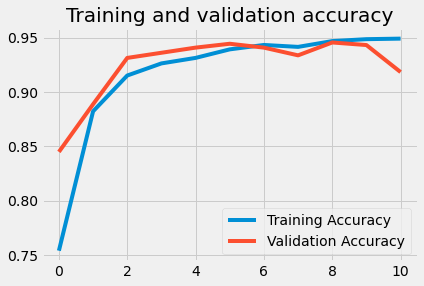

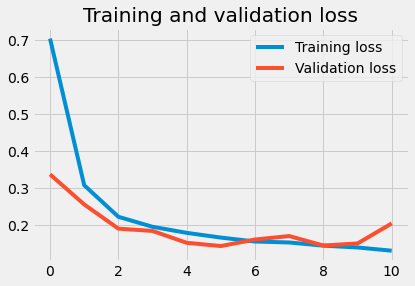

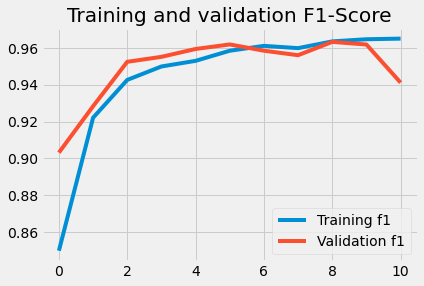

In [66]:
plot_performance(history)

In [67]:
model.evaluate(val_g, workers = 8, verbose = 2)
#loss: 0.1432 - accuracy: 0.9444 - recall: 0.9642 - precision: 0.9595

27/27 - 5s - loss: 0.1432 - accuracy: 0.9444 - recall: 0.9642 - precision: 0.9595
27/27 - 4s - loss: 0.1135 - accuracy: 0.9645 - recall: 0.9724 - precision: 0.9787


[0.1134578064084053, 0.9644970297813416, 0.9723577499389648, 0.978723406791687]

## Model 2 
The baseline has a pretty high performance. Let's try to perfect it. First, the training model seems to plateau at around 95 %. So let's try add some complexity to the model. First I'll try to add a layer.

In [68]:
# model fit
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape=(256, 256, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# compiling models
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy', 'Recall', 'Precision'])

# early stopping
cp = EarlyStopping(patience = 5, restore_best_weights=True)

# training
start = timer()

history = model.fit(train_g, 
                    epochs=100, 
                    validation_data = val_g,
                    workers = 7, 
                    callbacks = [cp], 
                    verbose = 2
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/100
124/124 - 155s - loss: 0.4621 - accuracy: 0.7868 - recall: 0.9196 - precision: 0.8122 - val_loss: 0.2976 - val_accuracy: 0.9041 - val_recall: 0.8813 - val_precision: 0.9855
Epoch 2/100
124/124 - 159s - loss: 0.2433 - accuracy: 0.9030 - recall: 0.9408 - precision: 0.9270 - val_loss: 0.1637 - val_accuracy: 0.9337 - val_recall: 0.9610 - val_precision: 0.9486
Epoch 3/100
124/124 - 158s - loss: 0.1717 - accuracy: 0.9364 - recall: 0.9593 - precision: 0.9536 - val_loss: 0.1356 - val_accuracy: 0.9503 - val_recall: 0.9675 - val_precision: 0.9643
Epoch 4/100
124/124 - 158s - loss: 0.1323 - accuracy: 0.9529 - recall: 0.9683 - precision: 0.9670 - val_loss: 0.1182 - val_accuracy: 0.9598 - val_recall: 0.9756 - val_precision: 0.9693
Epoch 5/100
124/124 - 159s - loss: 0.1240 - accuracy: 0.9509 - recall: 0.9676 - precision: 0.9649 - val_loss: 0.1167 - val_accuracy: 0.9586 - val_recall: 0.9772 - val_precision: 0.9662
Epoch 6/100
124/124 - 163s - loss: 0.1087 - accuracy: 0.9602 - recall: 0.97

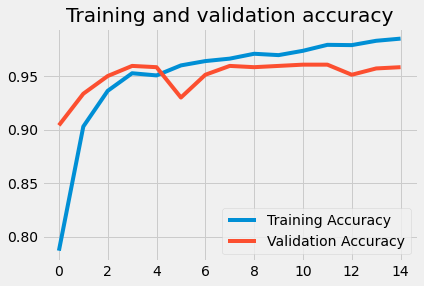

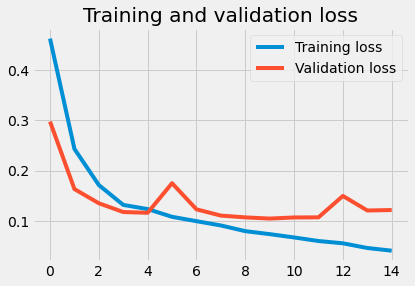

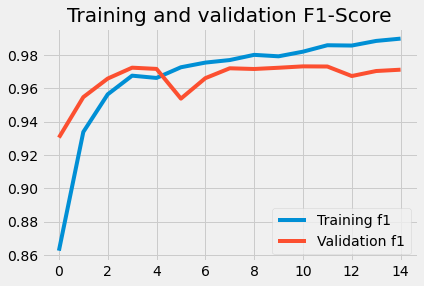

27/27 - 8s - loss: 0.1052 - accuracy: 0.9598 - recall: 0.9740 - precision: 0.9708


[0.10520976036787033,
 0.9597632884979248,
 0.9739837646484375,
 0.9708265662193298]

In [69]:
plot_performance(history)
model.evaluate(val_g, workers = 8, verbose = 2)

## Model 3
The above model did improve in performance. But it seems like performance on training data can improve. So I'll try to increase the complexity.

In [70]:
# model fit
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape=(256, 256, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# compiling models
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy', 'Recall', 'Precision'])

# early stopping
cp = EarlyStopping(patience = 5, restore_best_weights=True)

# training
start = timer()

history = model.fit(train_g, 
                    epochs=100, 
                    validation_data = val_g,
                    workers = 7, 
                    callbacks = [cp], 
                    verbose = 2
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/100
124/124 - 239s - loss: 0.3080 - accuracy: 0.8655 - recall: 0.9370 - precision: 0.8849 - val_loss: 0.1500 - val_accuracy: 0.9420 - val_recall: 0.9382 - val_precision: 0.9813
Epoch 2/100
124/124 - 238s - loss: 0.1495 - accuracy: 0.9415 - recall: 0.9582 - precision: 0.9612 - val_loss: 0.1597 - val_accuracy: 0.9349 - val_recall: 0.9886 - val_precision: 0.9268
Epoch 3/100
124/124 - 238s - loss: 0.1244 - accuracy: 0.9567 - recall: 0.9708 - precision: 0.9697 - val_loss: 0.1253 - val_accuracy: 0.9574 - val_recall: 0.9805 - val_precision: 0.9617
Epoch 4/100
124/124 - 238s - loss: 0.1097 - accuracy: 0.9577 - recall: 0.9722 - precision: 0.9698 - val_loss: 0.1178 - val_accuracy: 0.9609 - val_recall: 0.9772 - val_precision: 0.9694
Epoch 5/100
124/124 - 238s - loss: 0.0994 - accuracy: 0.9635 - recall: 0.9760 - precision: 0.9739 - val_loss: 0.1240 - val_accuracy: 0.9550 - val_recall: 0.9577 - val_precision: 0.9800
Epoch 6/100
124/124 - 237s - loss: 0.0900 - accuracy: 0.9681 - recall: 0.98

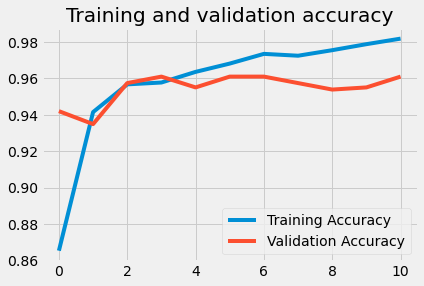

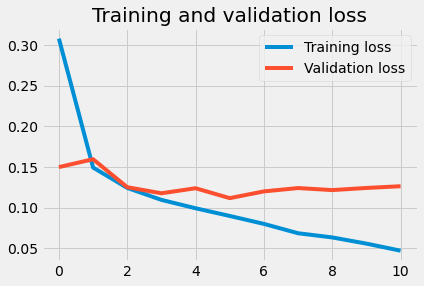

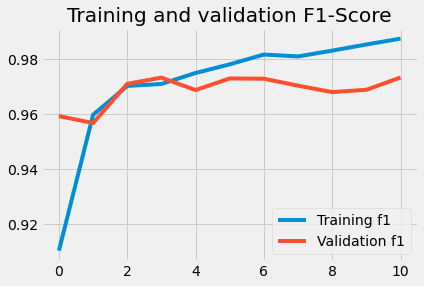

27/27 - 11s - loss: 0.1119 - accuracy: 0.9609 - recall: 0.9659 - precision: 0.9802


[0.11186925321817398,
 0.9609467387199402,
 0.9658536314964294,
 0.9801980257034302]

In [71]:
plot_performance(history)
model.evaluate(val_g, workers = 8, verbose = 2)

## Model 4
The above model did improve a bit. Let's try different optimizer.

In [72]:
# model fit
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape=(256, 256, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# compiling models
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(amsgrad = True),
              metrics=['accuracy', 'Recall', 'Precision'])

# early stopping
cp = EarlyStopping(patience = 5, restore_best_weights=True)

# training
start = timer()

history = model.fit(train_g, 
                    epochs=100, 
                    validation_data = val_g,
                    workers = 7, 
                    callbacks = [cp], 
                    verbose = 2
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/100
124/124 - 222s - loss: 0.3742 - accuracy: 0.8516 - recall: 0.9210 - precision: 0.8805 - val_loss: 0.1426 - val_accuracy: 0.9444 - val_recall: 0.9528 - val_precision: 0.9702
Epoch 2/100
124/124 - 222s - loss: 0.1322 - accuracy: 0.9499 - recall: 0.9666 - precision: 0.9646 - val_loss: 0.1354 - val_accuracy: 0.9491 - val_recall: 0.9480 - val_precision: 0.9815
Epoch 3/100
124/124 - 222s - loss: 0.1025 - accuracy: 0.9623 - recall: 0.9722 - precision: 0.9759 - val_loss: 0.1397 - val_accuracy: 0.9479 - val_recall: 0.9366 - val_precision: 0.9914
Epoch 4/100
124/124 - 221s - loss: 0.0872 - accuracy: 0.9676 - recall: 0.9770 - precision: 0.9784 - val_loss: 0.1345 - val_accuracy: 0.9562 - val_recall: 0.9512 - val_precision: 0.9882
Epoch 5/100
124/124 - 238s - loss: 0.0690 - accuracy: 0.9770 - recall: 0.9819 - precision: 0.9864 - val_loss: 0.1212 - val_accuracy: 0.9598 - val_recall: 0.9642 - val_precision: 0.9802
Epoch 6/100
124/124 - 224s - loss: 0.0545 - accuracy: 0.9808 - recall: 0.98

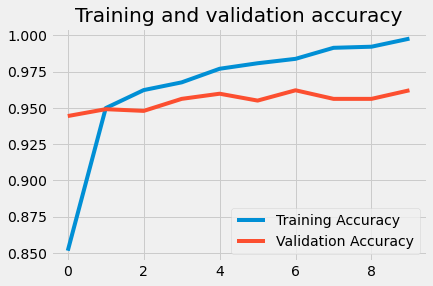

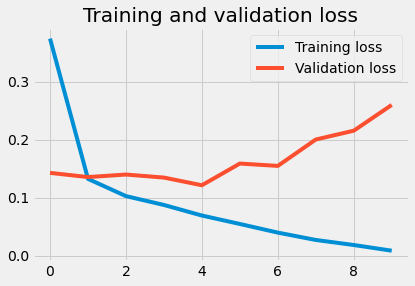

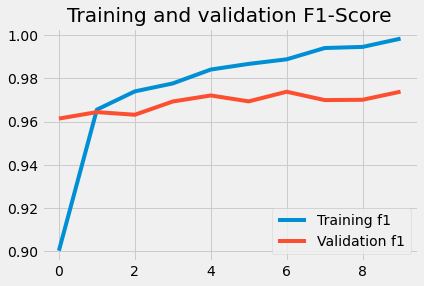

27/27 - 10s - loss: 0.1212 - accuracy: 0.9598 - recall: 0.9642 - precision: 0.9802


[0.12122920155525208,
 0.9597632884979248,
 0.9642276167869568,
 0.9801653027534485]

In [73]:
plot_performance(history)
model.evaluate(val_g, workers = 8, verbose = 2)

## Model 5
The above model did converge much faster. We will keep the optimizer. Now let's try to add data augmentation in order to increase the generalizability of the model since validation performance is not keeping up. But first, I want to test balancing class weight.

In [74]:
# find the weight
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', [0, 1], train_g.classes)
weights = dict(zip([0, 1], weights))

D:\ProgramData\Anaconda3\envs\workspace-gpu\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0, 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [75]:
# model fit
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape=(256, 256, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# compiling models
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(amsgrad = True),
              metrics=['accuracy', 'Recall', 'Precision'])

# early stopping
cp = EarlyStopping(patience = 5, restore_best_weights=True)

# training
start = timer()

history = model.fit(train_g, 
                    epochs=100, 
                    validation_data = val_g,
                    class_weight=weights,
                    workers = 7, 
                    callbacks = [cp], 
                    verbose = 2
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/100
124/124 - 241s - loss: 0.3538 - accuracy: 0.8645 - recall: 0.8611 - precision: 0.9479 - val_loss: 0.1215 - val_accuracy: 0.9562 - val_recall: 0.9707 - val_precision: 0.9692
Epoch 2/100
124/124 - 230s - loss: 0.1467 - accuracy: 0.9440 - recall: 0.9429 - precision: 0.9794 - val_loss: 0.1699 - val_accuracy: 0.9467 - val_recall: 0.9366 - val_precision: 0.9897
Epoch 3/100
124/124 - 219s - loss: 0.1257 - accuracy: 0.9529 - recall: 0.9499 - precision: 0.9848 - val_loss: 0.1253 - val_accuracy: 0.9586 - val_recall: 0.9659 - val_precision: 0.9770
Epoch 4/100
124/124 - 220s - loss: 0.0835 - accuracy: 0.9676 - recall: 0.9666 - precision: 0.9886 - val_loss: 0.1402 - val_accuracy: 0.9562 - val_recall: 0.9610 - val_precision: 0.9785
Epoch 5/100
124/124 - 220s - loss: 0.0701 - accuracy: 0.9719 - recall: 0.9708 - precision: 0.9904 - val_loss: 0.1662 - val_accuracy: 0.9538 - val_recall: 0.9480 - val_precision: 0.9881
Epoch 6/100
124/124 - 219s - loss: 0.0447 - accuracy: 0.9830 - recall: 0.97

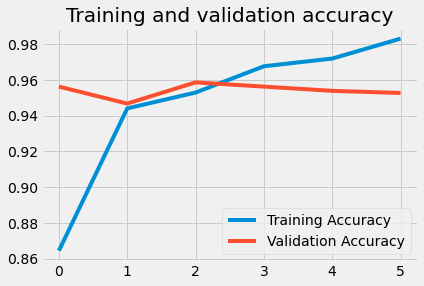

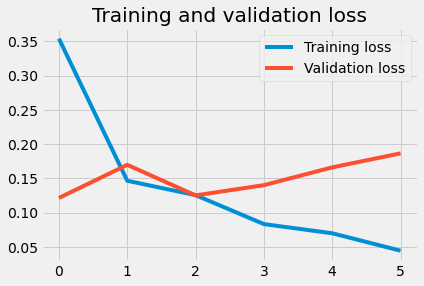

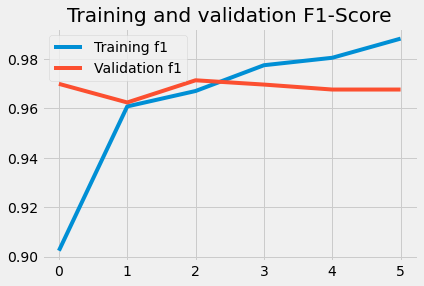

27/27 - 11s - loss: 0.1215 - accuracy: 0.9562 - recall: 0.9707 - precision: 0.9692


[0.1215362623333931,
 0.9562129974365234,
 0.9707317352294922,
 0.9691558480262756]

In [76]:
plot_performance(history)
model.evaluate(val_g, workers = 8, verbose = 2)

In [77]:
# saving model
model.save('MODEL/new_model_5.h5')

## Model 6
Now let's try to add the data augmentation.

In [6]:
data_aug_train = image.ImageDataGenerator(rescale = 1/255,
                                          rotation_range = 15,
                                          brightness_range = [0.9, 1.1],
                                          shear_range=5,
                                          zoom_range = 0.2)

train_g2 = data_aug_train.flow_from_directory(train_dir,
                                              target_size = (256,256), 
                                              color_mode='grayscale',
                                              class_mode='binary')

Found 3949 images belonging to 2 classes.


In [7]:
# model fit
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape=(256, 256, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# compiling models
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(amsgrad = True),
              metrics=['accuracy', 'Recall', 'Precision'])

# early stopping
cp = EarlyStopping(patience = 5, restore_best_weights=True)

# training
start = timer()

history = model.fit(train_g2, 
                    epochs=100, 
                    validation_data = val_g,
                    workers = 7, 
                    callbacks = [cp], 
                    verbose = 2
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/100
124/124 - 212s - loss: 0.4065 - accuracy: 0.8476 - recall: 0.9203 - precision: 0.8764 - val_loss: 0.1736 - val_accuracy: 0.9337 - val_recall: 0.9301 - val_precision: 0.9778
Epoch 2/100
124/124 - 211s - loss: 0.2268 - accuracy: 0.9073 - recall: 0.9363 - precision: 0.9363 - val_loss: 0.1520 - val_accuracy: 0.9479 - val_recall: 0.9496 - val_precision: 0.9782
Epoch 3/100
124/124 - 212s - loss: 0.2045 - accuracy: 0.9167 - recall: 0.9426 - precision: 0.9429 - val_loss: 0.1594 - val_accuracy: 0.9337 - val_recall: 0.9659 - val_precision: 0.9444
Epoch 4/100
124/124 - 212s - loss: 0.1893 - accuracy: 0.9258 - recall: 0.9506 - precision: 0.9476 - val_loss: 0.1332 - val_accuracy: 0.9538 - val_recall: 0.9593 - val_precision: 0.9768
Epoch 5/100
124/124 - 211s - loss: 0.1720 - accuracy: 0.9339 - recall: 0.9537 - precision: 0.9554 - val_loss: 0.1204 - val_accuracy: 0.9456 - val_recall: 0.9691 - val_precision: 0.9567
Epoch 6/100
124/124 - 209s - loss: 0.1678 - accuracy: 0.9314 - recall: 0.94

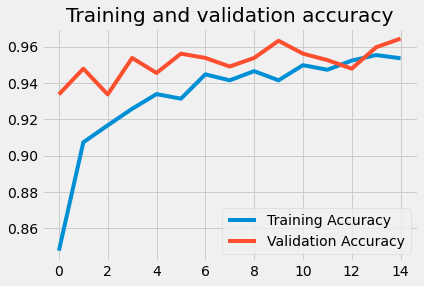

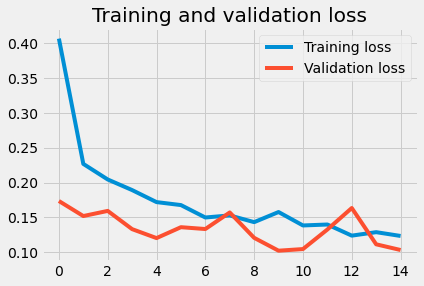

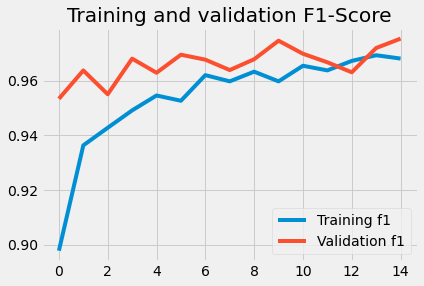

27/27 - 10s - loss: 0.1023 - accuracy: 0.9633 - recall: 0.9659 - precision: 0.9834


[0.10232038050889969,
 0.963313639163971,
 0.9658536314964294,
 0.9834437370300293]

In [8]:
plot_performance(history)
model.evaluate(val_g, workers = 8, verbose = 2)

In [9]:
# saving model
model.save('MODEL/new_model_6.h5')

## Model 7
Adding complexity

In [10]:
# model fit
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape=(256, 256, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# compiling models
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(amsgrad = True),
              metrics=['accuracy', 'Recall', 'Precision'])

# early stopping
cp = EarlyStopping(patience = 5, restore_best_weights=True)

# training
start = timer()

history = model.fit(train_g2, 
                    epochs=100, 
                    validation_data = val_g,
                    workers = 7, 
                    callbacks = [cp], 
                    verbose = 2
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/100
124/124 - 249s - loss: 0.4655 - accuracy: 0.7799 - recall: 0.9105 - precision: 0.8104 - val_loss: 0.2798 - val_accuracy: 0.8639 - val_recall: 0.9756 - val_precision: 0.8571
Epoch 2/100
124/124 - 252s - loss: 0.2618 - accuracy: 0.8911 - recall: 0.9290 - precision: 0.9219 - val_loss: 0.1792 - val_accuracy: 0.9337 - val_recall: 0.9203 - val_precision: 0.9878
Epoch 3/100
124/124 - 252s - loss: 0.1885 - accuracy: 0.9319 - recall: 0.9523 - precision: 0.9540 - val_loss: 0.1614 - val_accuracy: 0.9444 - val_recall: 0.9301 - val_precision: 0.9931
Epoch 4/100
124/124 - 250s - loss: 0.1809 - accuracy: 0.9331 - recall: 0.9488 - precision: 0.9588 - val_loss: 0.1252 - val_accuracy: 0.9562 - val_recall: 0.9480 - val_precision: 0.9915
Epoch 5/100
124/124 - 251s - loss: 0.1698 - accuracy: 0.9349 - recall: 0.9506 - precision: 0.9596 - val_loss: 0.1246 - val_accuracy: 0.9538 - val_recall: 0.9854 - val_precision: 0.9528
Epoch 6/100
124/124 - 250s - loss: 0.1528 - accuracy: 0.9405 - recall: 0.95

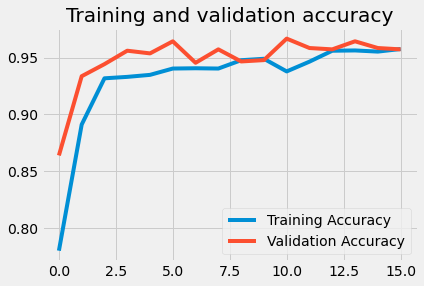

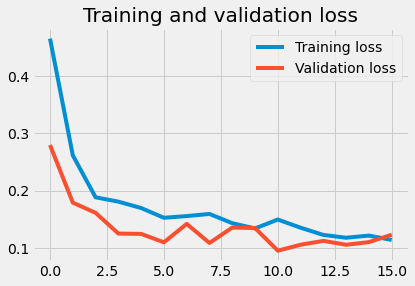

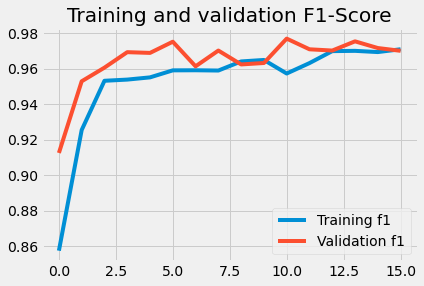

27/27 - 12s - loss: 0.0953 - accuracy: 0.9669 - recall: 0.9610 - precision: 0.9933


[0.0952979251742363,
 0.9668639302253723,
 0.9609755873680115,
 0.9932773113250732]

In [11]:
plot_performance(history)
model.evaluate(val_g, workers = 8, verbose = 2)

In [12]:
# saving model
model.save('MODEL/new_model_7.h5')

## Model 8
Adding complexity

In [17]:
# model fit
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape=(256, 256, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(2048, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# compiling models
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(amsgrad = True),
              metrics=['accuracy', 'Recall', 'Precision'])

# early stopping
cp = EarlyStopping(patience = 5, restore_best_weights=True)

# training
start = timer()

history = model.fit(train_g2, 
                    epochs=100, 
                    validation_data = val_g,
                    workers = 7, 
                    callbacks = [cp], 
                    verbose = 2
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/100
124/124 - 299s - loss: 0.3922 - accuracy: 0.8156 - recall: 0.9085 - precision: 0.8488 - val_loss: 0.2871 - val_accuracy: 0.8604 - val_recall: 0.9740 - val_precision: 0.8545
Epoch 2/100
124/124 - 296s - loss: 0.2652 - accuracy: 0.8931 - recall: 0.9234 - precision: 0.9292 - val_loss: 0.1691 - val_accuracy: 0.9278 - val_recall: 0.9675 - val_precision: 0.9355
Epoch 3/100
124/124 - 294s - loss: 0.2266 - accuracy: 0.9058 - recall: 0.9353 - precision: 0.9353 - val_loss: 0.1457 - val_accuracy: 0.9408 - val_recall: 0.9610 - val_precision: 0.9579
Epoch 4/100
124/124 - 300s - loss: 0.1971 - accuracy: 0.9210 - recall: 0.9464 - precision: 0.9451 - val_loss: 0.1312 - val_accuracy: 0.9515 - val_recall: 0.9561 - val_precision: 0.9767
Epoch 5/100
124/124 - 296s - loss: 0.1913 - accuracy: 0.9228 - recall: 0.9450 - precision: 0.9486 - val_loss: 0.1369 - val_accuracy: 0.9444 - val_recall: 0.9691 - val_precision: 0.9551
Epoch 6/100
124/124 - 295s - loss: 0.1873 - accuracy: 0.9238 - recall: 0.94

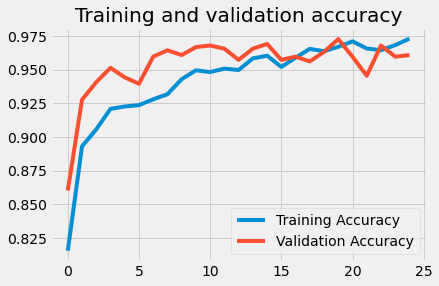

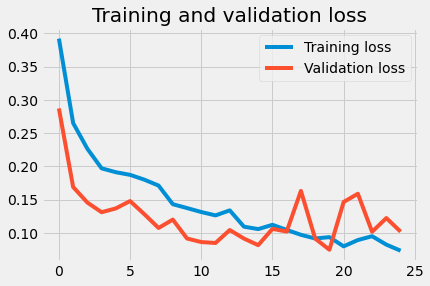

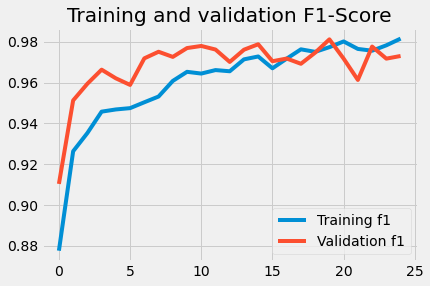

27/27 - 14s - loss: 0.0748 - accuracy: 0.9728 - recall: 0.9740 - precision: 0.9884


[0.07478828728199005,
 0.9727810621261597,
 0.9739837646484375,
 0.9884488582611084]

In [18]:
plot_performance(history)
model.evaluate(val_g, workers = 8, verbose = 2)

In [19]:
# saving model
model.save('MODEL/new_model_8.h5')

## Model 9
Adding complexity and increasing the degree of data augmentation

In [34]:
data_aug_train2 = image.ImageDataGenerator(rescale = 1/255,
                                          rotation_range = 20,
                                          brightness_range = [0.8, 1.2],
                                          shear_range=5,
                                          zoom_range = 0.2)

train_g3 = data_aug_train2.flow_from_directory(train_dir,
                                              target_size = (256,256), 
                                              color_mode='grayscale',
                                              class_mode='binary')

Found 3949 images belonging to 2 classes.


In [ ]:
# model fit
model = models.Sequential()
model.add(layers.Conv2D(64, 7, activation = 'relu', padding = 'same', input_shape=(256, 256, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 5, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, 3, activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(2048, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# compiling models
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(amsgrad = True),
              metrics=['accuracy', 'Recall', 'Precision'])

# early stopping
cp = EarlyStopping(patience = 5, restore_best_weights=True)

# training
start = timer()

history = model.fit(train_g3, 
                    epochs=100, 
                    validation_data = val_g,
                    workers = 3, 
                    callbacks = [cp], 
                    verbose = 2
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/100
124/124 - 1436s - loss: 0.9791 - accuracy: 0.7701 - recall: 0.8959 - precision: 0.8087 - val_loss: 0.2301 - val_accuracy: 0.9077 - val_recall: 0.9220 - val_precision: 0.9497
Epoch 2/100
124/124 - 1466s - loss: 0.2845 - accuracy: 0.8800 - recall: 0.9224 - precision: 0.9135 - val_loss: 0.1936 - val_accuracy: 0.9337 - val_recall: 0.9252 - val_precision: 0.9827
Epoch 3/100
124/124 - 1416s - loss: 0.2546 - accuracy: 0.8992 - recall: 0.9262 - precision: 0.9347 - val_loss: 0.1702 - val_accuracy: 0.9373 - val_recall: 0.9577 - val_precision: 0.9562
Epoch 4/100
124/124 - 1424s - loss: 0.2624 - accuracy: 0.9002 - recall: 0.9349 - precision: 0.9284 - val_loss: 0.1967 - val_accuracy: 0.9195 - val_recall: 0.9642 - val_precision: 0.9280
Epoch 5/100
124/124 - 1349s - loss: 0.2148 - accuracy: 0.9200 - recall: 0.9405 - precision: 0.9491 - val_loss: 0.1395 - val_accuracy: 0.9550 - val_recall: 0.9480 - val_precision: 0.9898
Epoch 6/100


In [ ]:
plot_performance(history)
model.evaluate(val_g, workers = 8, verbose = 2)

In [ ]:
# saving model
model.save('MODEL/new_model_9.h5')

# Review
---
Our final model is model4 with .95 accuracy. Let's see where this model failed.

In [251]:
model = models.load_model('MODEL/model4.h5')

## Visualizing Where Model Failed
Using a model with 95% accuracy, we'll take a look at where our model failed.

ImageDataGenerator is not returning correct indices for prediction, even after setting shuffling to False, so instead we'll iterate through each file and figure out the prediction. This is possible because test set is relatively small (< 600)

In [254]:
test_g0 = image.ImageDataGenerator(rescale = 1/255)

def get_pred(path):
    filelist = os.listdir(path)
    result = {}

    for fn in filelist:
        image_ = image.load_img(f'{path}/{fn}', 
                                target_size = (150,150), 
                                color_mode='grayscale')
        input_ = np.array([image.img_to_array(image_)])
        input_f = test_g0.flow(input_)
        result[fn] = int(np.where(model.predict(input_f)[0] > 0.5, 1, 0))
    return result

In [255]:
Neg_class_preds = get_pred('DATA/test/normal')
Pos_class_preds = get_pred('DATA/test/pneumonia')

In [256]:
FP_list = [k for k, v in Neg_class_preds.items() if v != 0]
FN_list = [k for k, v in Pos_class_preds.items() if v != 1]

### Confusion Matrix

In [281]:
# getting numbers for confusion matrix
FP = len(FP_list)
FN = len(FN_list)
TP = len(Pos_class_preds) - FP
TN = len(Neg_class_preds) - FN

In [282]:
TP, FN, FP, TN

(332, 10, 20, 224)

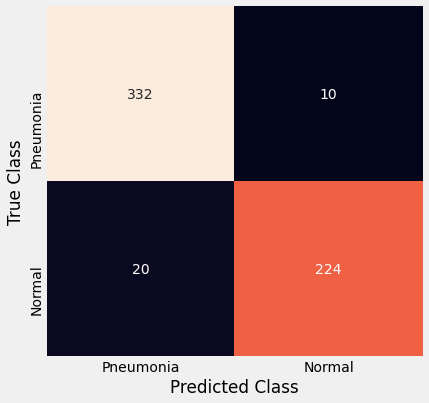

In [284]:
import seaborn as sns
cm = [[TP, FN], [FP, TN]]
plt.figure(figsize = (6, 6))
sns.heatmap(cm, annot=True, fmt="d", cbar = False, xticklabels=['Pneumonia', 'Normal'], yticklabels = ['Pneumonia', 'Normal'])
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

### Sample Wrong Predictions

In [261]:
def plot_img(path, title):
    fn = image.load_img(path, color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(title)
    plt.axis('off')
    plt.show()

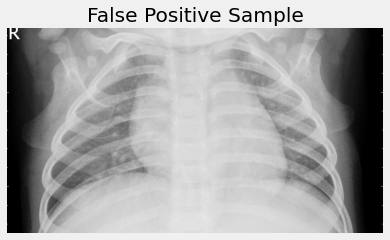

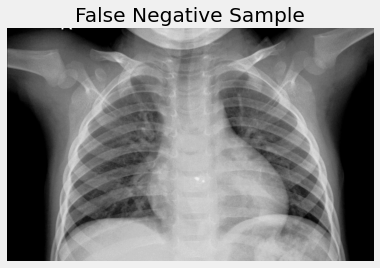

In [272]:
plot_img(f'DATA/test/normal/{np.random.choice(FP_list, 1)[0]}', 'False Positive Sample')
plot_img(f'DATA/test/pneumonia/{np.random.choice(FN_list, 1)[0]}', 'False Negative Sample')

It seems like the model is missing high contrast pneumonia cases and low contrast normal cases. For the future, possibly training at more fine grain pixels may help.